## Load libraries

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
import os,sys
import re
import math
from datetime import datetime
import time
sys.dont_write_bytecode = True

In [ ]:
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from pathlib import Path
from typing import List, Set, Dict, Tuple, Optional, Iterable, Mapping, Union, Callable, TypeVar
import warnings
from pprint import pprint
from ipdb import set_trace as brpt

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from  torch.linalg import norm as tnorm
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision

import pytorch_lightning as pl
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.tuner.tuning import Tuner

# Select Visible GPU
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

## Set Path 
1. Add project root and src folders to `sys.path`
2. Set DATA_ROOT to `maptile_v2` folder

In [ ]:
this_nb_path = Path(os.getcwd())
ROOT = this_nb_path.parent
SRC = ROOT/'src'
DATA_ROOT = Path("/data/hayley-old/maptiles_v2/")
paths2add = [this_nb_path, ROOT]

print("Project root: ", str(ROOT))
print('Src folder: ', str(SRC))
print("This nb path: ", str(this_nb_path))


for p in paths2add:
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"\n{str(p)} added to the path.")
        
print(sys.path)

In [ ]:
from src.data.datasets.maptiles import MaptilesDataset, MapStyles
from src.data.datamodules.maptiles_datamodule import MaptilesDataModule

from src.data.transforms.transforms import Identity, Unnormalizer, LinearRescaler
from src.data.transforms.functional import unnormalize
from src.models.plmodules.three_fcs import ThreeFCs

from src.visualize.utils import show_timgs, show_batch
from src.utils.misc import info
from src.models.model_wrapper import ModelWrapper


from collections import OrderedDict


In [ ]:
def show_batch(dm: MaptilesDataModule, n_show: int=16, **kwargs):
    """
    -kwargs will be passed into `show_timgs` function
        - titles: a list of titles for axes; must be the same length as the number of npimgs
        - nrows
        - factor
        - cmap (str): eg. "gray"
        - title (for the main figure's suptitle)
    """
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", module="matplotlib*")
        # Show a batch of train data
        # - before/after channelwise normalization
        x,y = next(iter(dm.train_dataloader()))
        train_mean, train_std = dm.train_mean, dm.train_std

        # Undo normalization
        x_unnormed = unnormalize(x, train_mean, train_std)
        
        info(x, "batch x")
        info(x_unnormed, "unnormalized x")
        show_timgs(x_unnormed[:n_show], **kwargs)

In [ ]:
class MyTrainer(pl.Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs) #check if this sets train/val dataloaders
        self.num_data = len(self.train_dataloader().dataset)

    def get_dl(mode: str, dl_idx:int=0):
        if mode == 'train':
            dl = getattr(self, "train_dataloader")
        else:
            dl = getattr(self, f"{mode}_dataloaders")[dl_idx]
        print(dl)
        print(dl.dataset)
        return dl
    
    def get_next_batch(mode: str, dl_idx):
        dl = self.get_dl(mode, dl_idx)
        return next(iter(dl))
    

In [ ]:
def test_maptiles_dataset():
    cities = ['paris']
    styles = ['CartoVoyagerNoLabels', 'StamenTonerBackground']
    zooms = ['15']
    n_channels = 3
    dset = MaptilesDataset(
        data_root=DATA_ROOT,
        cities=cities, 
        styles=styles, 
        zooms=zooms, 
        n_channels=in_channels
    )
    train_dset, val_dset = MaptilesDataset.random_split(dset, 0.9)
    train_channel_mean, train_channel_std = train_dset.channel_mean, train_dset.channel_std

    [print(len(x)) for x in [dset, train_dset, val_dset]];
    [print(x.channel_mean, x.channel_std) for x in [dset, train_dset, val_dset]];
    
def test_maptiles_datamodule_factory():
    cities = ['paris']
    styles = ['CartoVoyagerNoLabels', 'StamenTonerBackground']
    zooms = ['15']
    n_channels = 3
    dset = MaptilesDataset(
        data_root=DATA_ROOT,
        cities=cities, 
        styles=styles, 
        zooms=zooms, 
        n_channels=in_channels
    )
    
    in_shape = (n_channels, 64,64)
    dm = MaptilesDataModule.from_maptiles_dataset(dset, in_shape=in_shape )
    dm.setup('test')
    print(dm.train_ds.channel_mean, dm.train_ds.channel_std)
    print(dm.train_ds.transform)
    print(dm.val_ds.transform)
    print(dm.test_ds.transform)

## Start experiment 
Given a maptile, predict its style as one of OSM, CartoVoyager

In [ ]:
from src.models.plmodules.vanilla_vae import VanillaVAE
from src.data.datamodules.maptiles_datamodule import MaptilesDataModule
from src.data.datamodules.mnist_datamodule import MNISTDataModule

- Instantiate data module

In [ ]:
cities = ['berlin']#['paris'] #
# styles = ['OSMDefault', 'CartoVoyagerNoLabels', 'StamenTonerBackground']
styles = ['StamenTonerBackground']#['CartoVoyagerNoLabels']#, 'StamenTonerBackground']

zooms = ['15']
n_channels = 1
dset = MaptilesDataset(
        data_root=DATA_ROOT,
        cities=cities, 
        styles=styles, 
        zooms=zooms, 
        n_channels=n_channels
    )

In [ ]:
in_shape = (n_channels, 32,32)
bs = 128
dm = MaptilesDataModule.from_maptiles_dataset(dset, in_shape=in_shape, batch_size=bs )
dm.setup('fit')
print(dm.train_ds.channel_mean, dm.train_ds.channel_std)
print(dm.train_ds.transform)
print(dm.val_ds.transform)
# print(dm.test_ds.transform)

In [ ]:
# dm.train_ds.show_samples(order='chw')
# show_batch(dm, cmap='gray')

- Instantiate the pl Module

In [ ]:
latent_dim = 10
hidden_dims = [32,64,128,256]#,512]
act_fn = nn.ReLU()
lr = 1e-3
size_average = False
model = VanillaVAE(in_shape=dm.size(), #dm.in_shape, 
                    latent_dim=latent_dim,
                    hidden_dims=hidden_dims,
                    act_fn=act_fn,
                  learning_rate=lr,
                  size_average=size_average)
pprint(dm.hparams)
pprint(model.hparams)

- Instantiate a PL `Trainer` object
    - most basic trainer: uses good defaults, eg: auto-tensorboard logging, checkpoints, logs, etc.
    - Pass the data module along with a pl module
    - Ref: https://www.learnopencv.com/tensorboard-with-pytorch-lightning/

In [ ]:
# Add Callbacks
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
callbacks = [
        HistogramLogger(hist_epoch_interval=1),
        ReconLogger(recon_epoch_interval=1),
#         EarlyStopping('val_loss', patience=10),
]

# Start the experiment
exp_name = f'{model.name}_{dm.train_ds}'
tb_logger = pl_loggers.TensorBoardLogger(save_dir=f'{ROOT}/temp-logs', 
                                         name=exp_name,
                                         log_graph=False,
                                        default_hp_metric=False)
print(tb_logger.log_dir)

# Log computational graph
model_wrapper = ModelWrapper(model)
tb_logger.experiment.add_graph(model_wrapper, model.example_input_array.to(model.device))
# tb_logger.log_graph(model)

trainer_config = {
    'gpus':1,
    'max_epochs': 3,
    'progress_bar_refresh_rate':20,
#     'auto_lr_find': True,
    'terminate_on_nan':True,
#     'num_sanity_val_steps':0.25,
    'check_val_every_n_epoch':10,
    'logger':tb_logger,
    'callbacks':callbacks,
}


# trainer = pl.Trainer(fast_dev_run=3)
trainer = pl.Trainer(**trainer_config)
# trainer.tune(model=model, datamodule=dm)

In [ ]:
# Fit model
trainer.fit(model, dm)
print(f"Finished at ep {trainer.current_epoch, trainer.batch_idx}")

---

## Log  hparmeters and `best_score` to tensorboard

In [ ]:
hparams = model.hparams.copy()
hparams.update(dm.hparams)
best_score = trainer.checkpoint_callback.best_model_score.item()
metrics = {'hparam/best_score': best_score} #todo: define a metric and use it here
print(hparams)
print("=")
print(metrics)

In [ ]:
# Use pl.Logger's method "log_hyperparameters" which handles the 
# hparams' element's formats to be suitable for Tensorboard logging
# See: 
# https://sourcegraph.com/github.com/PyTorchLightning/pytorch-lightning@be3e8701cebfc59bec97d0c7717bb5e52afc665e/-/blob/pytorch_lightning/loggers/tensorboard.py#explorer:~:text=def%20log_hyperparams
best_score = trainer.checkpoint_callback.best_model_score.item()
metrics = {'hparam/best_score': best_score} #todo: define a metric and use it here
trainer.logger.log_hyperparams(hparams, metrics)

## Evaluation
1. Reconstructions
    - Given x from train/val/test dataset, show N (eg. 16) number of possible reconstruction
    - Workflow: 
        - x --> model.encoder(x) --> theta_z --> sample N latent codes from the Pr(z; theta_z) --> model.decoder(z) for each sampled z's 
2. Inspect the topology/landscape of the learned latent space
    - Latent traversal: Pick a dimension of the latent space. Keep all other dimensions' values constant. Vary the chosen dimenion's values (eg. linearly, spherically) and decode the latent codes. Show the outputs of the decoder.
    
3. Mutual information
    - Between x and x_sample for N number of x_samples.
    - Between each dimensions of a latent code
    

## (estimate) Marginal Loglikelihood of train/val/test dataset
- Option1: $ELBO_{VAE}$

Steps:
1. Sample a bunch of z's from the chosen prior. Note **not!** from the learned q dist.
2. mu_x = model.decoder(sampled_z)
3. Compute (avg) likelihood of input batch x under Gaussian(mu_x, Identity cov)
4. Return the log of the avged likelihood. Note: log cannot be moved inside the averaging/expectation.

See [reddit](https://www.reddit.com/r/MachineLearning/comments/5qm6ag/d_how_to_calculate_variational_autoencoder_log/dd0xt0o?utm_source=share&utm_medium=web2x&context=3)

- Option2: $\mathcal{L}_{lwae}$ (better) 

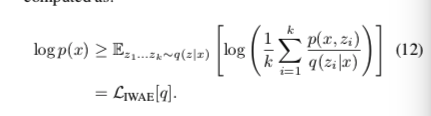

In [ ]:
d = Normal(torch.tensor(0.),1.)
d = d.expand([10,2])
d.sample()
# x = torch.tensor(

# todo:
- [ ] test this function
- [ ] make into a functino 
- [ ] loop over dl; compute for each single batch x
- Use log-exp-sum?
- do it in cpu?
- see https://github.com/tonywu95/eval_gen

In [ ]:
# Compute log marginal likelihood via IWAE
# x is a single batch: (BS=1, c, h,w)
model.eval()
with torch.no_grad():
    mu, log_var = model.encode(x[[0]]) #mu: (1, latent_dim), log_var: (1, latent_dim)
    breakpoint()

    q_z = Normal(mu.squeeze(), log_var.exp().squeeze())
    # Collect z's sampled from q(.|mu, log_var)
    n_samples = 5
    z_samples = model.reparameterize(
        mu.repeat(n_samples,1), 
        log_var.repeat(n_samples,1)
    ) # (n_samples, latent_dim)

    log_probs_q = q_z.log_prob(z_samples).sum(dim=1) #(n_samples)
    probs_q = log_probs.exp()
    # ---denom

    #--- top
    # p(x,z) = p(x|z)*p(z)
    # First compute logp(x,z) = logp(x|z) + log p(z)
    # Then exp.
    prior = Normal(0, 1)
    log_probs_prior = prior.log_prob(z_samples).sum(dim=1) #(n_samples,)

    mu_x = model.generate(z_samples) #(n_samples,c,h,w)
    p_xgz = Normal(mu_x,1)
    print(p_xgz.batch_shape, p_xgz.event_shape)
    # vs. x is a single batch (1, chw); we want each mu_x[i]
    # to be used to compute (n_sample) number of (chw) sized log_probs -> sum over (chw)
    # -> end up with (n_sample,) for (a part of ) numerator
    log_probs_p_xgz = p_xgz.log_prob(x.repeat((n_samples, *x.shape))).sum(dim=(1,2,3))
    log_top = log_probs_p_xgz + log_probs_prior
    top = log_top.exp()

    #log-exp-sum?
    les = logexpsum(log_top - log_probs_q)
    lwse = (les.exp()/n_samples).log()


    inside = torch.mean(top/probs_q)

    lwae = inside.log()

In [ ]:
from torch.distributions import MultivariateNormal, Normal

In [ ]:
#Given mu_x (shape: (nC, H, W)) and x = (bs=1, C,H,W), compute its loglikelihood
# N(x; mu_x, Identity)
logp = torch.tensor(0.)
x = torch.tensor([-2., 0., 1.])
d = Normal(torch.tensor(0.), torch.tensor(1.0))
d.log_prob(x).exp()

In [ ]:
gaussian = lambda x: (-.5*(x)**2).exp() / np.sqrt(2*np.pi)
gaussian(x)

In [ ]:
bs = mu_x.shape[0] 
assert bs == 1
mu_x = mu_x[0]
d = Normal(mu_x, torch.ones(mu_x.shape))
d.log_prob(x)

In [ ]:
llhs = {}
with torch.no_grad():
    for mode in ['train', 'val']:
        prob_sum = torch.tensor(0.)
        n_imgs = 0
        dl = getattr(dm, f"{mode}_dataloader")()
        for (x,y) in dl:           
            bs = x.shape[0]
            
            # sample z -> decoder -> mu_x
            z_sample = torch.randn((bs, model.latent_dim), device=model.device)
            mu_x = model.decode(z_sample)
            
            dist = Normal(mu_x, torch.ones(mu_x.shape))
            log_prob = torch.sum(dist.log_prob(x), dim=(1,2,3)) # (bs,1)
            prob = log_prob#.exp()
            
            # Accumulate the sum over this batch
            prob_sum += torch.sum(prob)
            n_imgs += bs

        # Log of average likelihood of an image
        llhs[mode] = (prob_sum/n_imgs).item()
        
        
        

In [ ]:
                       
        x,y = next(iter(dl))
        x = x.to(model.device)
        x_recon = model.generate(x)    
sum_px = torch.tensor(0.0)

for x in batch_x:
    z_sampled = torch.distribution.Normal
    d = MultivariateNormal(mu[i], torch.diagflat(log_var[i].exp()))
assert d.batch_shape == ()
assert d.event_shape == (latent_dim,)
x = d.sample()
assert x.shape == (latent_dim,)            # == batch_shape + event_shape
assert d.log_prob(x[i]).shape == ()  # == batch_shape
print(d.log_prob(x[i]).exp())

In [ ]:
model.eval()

n_samples = 36
with torch.no_grad():
    sampled_recons = model.sample(n_samples, model.device)
    show_timgs(sampled_recons.detach())

In [ ]:
z_samples = 

### Recons of inputs from training data

In [ ]:
model.eval();

# Method1: Use a trainer to load a best checkpt.
# trainer.test(model, test_dataloaders=dm.test_dataloader())

In [ ]:
# Method2: Manually get the checkpoint path to the best model's weight
# -- See https://pytorch-lightning.readthedocs.io/en/stable/_modules/pytorch_lightning/trainer/trainer.html#Trainer.test
from pytorch_lightning.utilities.cloud_io import load as pl_load

ckpt_path = trainer.checkpoint_callback.best_model_path
ckpt = pl_load(ckpt_path, map_location=lambda storage, loc: storage) #dict object
model.load_state_dict(ckpt['state_dict'])

for k,v in ckpt.items():c
    if 'state' in k:
        continue
    pprint(f"{k}:{v}")

In [ ]:
# Method3: Get the last model

In [ ]:
def make_grid_from_tensors(tensors: List[torch.Tensor], dim: int=-1):
    """
    Args:
    - dim (int): 
        - use -1 to put the tensors side-by-side
        - use -2 to put them one below another
        
    Example:
    grid = make_grid_from_tensors([grid_input, grid_recon], dim=-1)
    tb_writer.add_image("input-recon", grid, global_step=0)
    """
    grids = [torchvision.utils.make_grid(t) for t in tensor] # each element has size, eg.(C, gridh, gridw)
    combined = torch.cat(grids, dim=dim)
    return combined

def log_recon(trainer, model, **kwargs):
    """
    Run it after train/val epoch
    kwargs:
    - dim (int): 
        - Use -1 for side-by-side stacking of x and x_recon.
        - Use -2 for up-down stacking of x and x_recon
    """ 
#     model.eval()
    train_mean, train_std = trainer.datamodule.train_mean, trainer.datamodule.train_std
    with torch.no_grad():
        for mode in ['train', 'val']:
            print("mode: ", mode, "\t\t is training: ", model.training)
            dl = getattr(model, f"{mode}_dataloader")()
            x,y = next(iter(dl))
            x = x.to(model.device)
            x_recon = model.generate(x)

            # unnormalize for visualization
            x = x.cpu()
            x_recon = x_recon.cpu()
            x_unnormed = unnormalize(x, train_mean, train_std)
            x_recon_unnormed = unnormalize(x_recon, train_mean, train_std)

            # Log input-recon grid to TB
            input_grid = torchvision.utils.make_grid(x_unnormed) # (C, gridh, gridw)
            recon_grid = torchvision.utils.make_grid(x_recon_unnormed) # (C, gridh, gridw)
            grid = torch.cat([input_grid, recon_grid], dim=-1) #inputs | recons
            trainer.logger.experiment.add_image(f"{mode}/recons", grid, global_step=model.current_epoch)
            
            
# log_recon(trainer, model)
        
            

In [ ]:
def log_hist_img_of_muz_varz(trainer, model, **kwargs):
    """

    """ 
    is_training = model.training
    model.eval()
    with torch.no_grad():
        mu,log_var = model.encode(x)
        f, ax = plt.subplots(1,2)
        ax = ax.flatten()
        ax[0].hist(mu, label='mu')
        ax[0].set_title('mu')
        ax[1].hist(log_var.exp(), label='var')
        ax[1].set_title('var')
            
        min_var = kwargs.get('min_var', None) or 1e-3
        n_tiny_vars = (log_var.exp() < min_var).sum()
        p_tiny = n_tiny_vars/log_var.numel()
        f.title(f"%tiny: {p_tiny}")
        
        # Log the figure to tensorboard
#         trainer.logger.experiment.add_img(f"{mode}/mu-and-var_z", f
    model.train(is_training)
    
def log_hist_of_params_of_q(trainer, model, **kwargs):
    """

    """ 
    is_training = model.training
    model.eval()
    with torch.no_grad():
        mu,log_var = model.encode(x)
        var_thresh = kwargs.get('var_thresh', None) or 1e-3
        n_tiny_vars = (log_var.exp() < var_thresh).sum()
        p_tiny = n_tiny_vars/log_var.numel()
        
        # Log the histograms to tensorboard
        trainer.logger.experiment.add_img(f"{mode}/centers of q", mu, global_step=model.current_epoch)
        trainer.logger.experiment.add_img(f"{mode}/vars of q", var, global_step=model.current_epoch)
        trainer.logger.experiment.add_scalar(f"{mode}/p_tiny_var", p_tiny, gloval_step=model.current_epoch)
    model.train(is_training)
    


In [ ]:
train_mean, train_std = dm.train_mean, dm.train_std
model.eval()
with torch.no_grad():
    for mode in ['train', 'val']:
        dl = getattr(model, f"{mode}_dataloader")()
        x,y = next(iter(dl))
        x = x.to(model.device)
        x_recon = model.generate(x)
        
        # unnormalize for visualization
        x = x.cpu()
        x_recon = x_recon.cpu()
        x_unnormed = unnormalize(x, train_mean, train_std)
        x_recon_unnormed = unnormalize(x_recon, train_mean, train_std)
        show_timgs(x_unnormed, title=f"{mode} dataset", cmap='gray')
        show_timgs(x_recon_unnormed, title=f"{mode}: recon", cmap='gray')
        show_timgs(LinearRescaler()(x_recon_unnormed), title=f"{mode}: recon", cmap='gray')
        
        # Print out
        info(x, f"{mode}_x")
        info(x_recon, f"{mode}_x_recon")
        print("===")
        info(x_unnormed, f"{mode}_x_unnormed")
        info(x_recon_unnormed, f"{mode}_x_recon_unnormed")
        
        # Log input-recon grid to TB
        input_grid = torchvision.utils.make_grid(x_unnormed) # (C, gridh, gridw)
        recon_grid = torchvision.utils.make_grid(x_recon_unnormed) # (C, gridh, gridw)
#         normed_recon_grid = torchvision.utils.make_grid(LinearRescaler()(x_recon_unnormed))
        grid = torch.cat([input_grid, recon_grid], dim=-1) #inputs | recons
        tb_logger.experiment.add_image(f"{mode}/recons", grid, global_step=0)
                            


todo:
- [ ] log recons at certain interval of train or val steps
- [ ] at the same time, log the below histogram of mu and var of latent space
    

In [ ]:
with torch.no_grad():
    mu,log_var = model.encode(x)
    f, ax = plt.subplots(1,2)
    ax = ax.flatten()
    ax[0].hist(mu, label='mu')
    ax[0].set_title('mu')
    ax[1].hist(log_var.exp(), label='var')
    ax[1].set_title('var')
    


In [ ]:
min_var = 1e-3
n_tiny_vars = (log_var.exp() < min_var).sum()
n_tiny_vars/log_var.numel()

In [ ]:
def sample_from_diag_gaussian(n_samples: int, mu: torch.Tensor, logvar: torch.Tensor)-> torch.Tensor:
    """
    Returns a tensor of shape (n_samples x dimension)
    from a gaussian with diagonal covariance and mean=mu.
    
    - mu: mini-batch of mu vectors; (bs, d)
    - logvar: mini-batch of logvar vectors; (bs, d)
    
    Note: logvar = torch.zeros((bs,d)) --> var = torch.ones((bs,d))
    Note: Preserves the gradient flow from the output to the input argument mu and logvar
    """

    std = (0.5*logvar).exp()
    eps = torch.randn_like(std)
    return mu + eps * std


    
    

### Recons of samples from learned latent space

In [ ]:
n_samples = 36
with torch.no_grad():
    sampled_recons = model.sample(n_samples, model.device)
    show_timgs(sampled_recons.detach(), cmap='gray')

## Visualize embeddings
- collect a batch of inputs -> encoder -> [mu, log_var] -> sample -> a batch of z's (embeddings)
- use tb logger


In [ ]:
model.eval()
with torch.no_grad():
    x, y = next(iter(trainer.train_dataloader))
    mu, log_var = model.encode(x)
    z = model.reparameterize(mu, log_var)
#     out = model.get_embeddings(x) # dict of mu, log_var, z
#     z = out['z']
    
    # log embedding to tensorboard 
    writer = model.logger.experiment
    writer.add_embedding(z,
                         label_img=LinearRescaler()(x), 
                         metadata=y.tolist(),
                         global_step=trainer.global_step, #todo
                        )
    
    



## Visualize original images of the close neighbors in the latent space
- Compute pairwise distance using cosine similarity
- For each row (ie. a latent code), get the index of the smallest values. 
- Select the images in the batch x and visualize (can do this all in show_timgs)



In [ ]:
from sklearn.metrics import pairwise_distances

In [ ]:
model.eval()
with torch.no_grad():
    x, y = next(iter(trainer.train_dataloader))
    mu, log_var = model.encode(x)
    z = model.reparameterize(mu, log_var)
    #     out = model.get_embeddings(x) # dict of mu, log_var, z
    #     z = out['z']metric = 'cosine'
    pdists = pairwise_distances(z.numpy(), metric=metric)
    plt.imshow(pdists, cmap='gray')
    plt.title("Pairwise dists of z's")
    plt.axis('off')
    plt.show()
    
    # smaller values means closer in distance
    n_ngbrs = 5
    n_rows = 100
    
    selected_rows = np.random.choice(len(x), size=n_rows)
    for idx in selected_rows:
        args = np.argsort(pdists[idx])[:n_ngbrs]
#         print(args)
        show_timgs(LinearRescaler()(x[args]), cmap='gray', factor=2, 
                   nrows=1, title=f'Nearest of img {idx}')

In [ ]:
# smaller values means closer in distance
n_ngbrs = 5
n_rows = 10
selected_rows = np.random.choice(len(x), size=n_rows)
for idx in selected_rows:
    args = np.argsort(pdists[idx])[:n_ngbrs]
    print(args)
    show_timgs(LinearRescaler()(x[args]), cmap='gray', factor=2, 
               nrows=1, title=f'Nearest of img {idx}')

In [ ]:
np.argsort(pdists[1])[:n_ngbrs]

In [ ]:
n_ngbrs = 5
args = np.argsort(pdists, axis=1)[:n_ngbrs]
print(args.shape)
# show_timgs(LinearRescaler()(x[args]), cmap='gray', factor=2, nrows=1)

## Latent Space Traversal
1. Linear traversal in a single dimension

In [ ]:
chosen_dim = 0 # must be in range(latent_dim)
fixed_vec = torch.randn((1, model.latent_dim-1))
fixed_values = fixed_vec.repeat((n_samples,1))
n_samples = 16
zi_min, zi_max = -2,2
varying = torch.linspace(zi_min, zi_max, n_samples).view((-1,1))

varying.shape,fixed_values.shape





In [ ]:
def construct_from(a_col:torch.Tensor, other_cols:torch.Tensor, ind):
    """
    Make a tensor from a column vector and a matrx containing all the other columns
    by inserting the `onc_column` at the final matrix's `ind`th column.
    """
    assert a_
    n_cols = 1 + 
    out = a_col.new_zeros((

## Implement an evaluation function

In [ ]:
from src.models.plmodules.utils import get_best_ckpt, load_model, load_best_model
from pytorch_lightning.utilities.cloud_io import load as pl_load


In [ ]:
def evaluate(model, 
             ckpt_path:str=None,
            tb_writer=None):
    if ckpt_path is None:
        load_best_model(model) #inplace
    else:
        load_model(model, ckpt_path) #inplace
    
    # ------------------------------------------------------------------------
    # Reconstruction 
    # ------------------------------------------------------------------------
    eval_recon(model, tb_writer=tb_writer)
    
    
                  
    

In [ ]:
def show_recon(model, unnormalize:bool=True, to_show:bool=False, verbose:bool=False):
    model.eval()
    dm = model.trainer.datamodule
    cmap = 'gray' if dm.in_shape[
    train_mean, train_std = dm.train_mean, dm.train_std
    with torch.no_grad():
        for mode in ['train', 'val']:
            dl = getattr(model, f"{mode}_dataloader")()
            x,y = next(iter(dl))
            x = x.to(model.device)
            x_recon = model.generate(x)

            x = x.cpu()
            x_recon = x_recon.cpu()
            
            if unnormalize:
                x_unnormed = unnormalize(x, train_mean, train_std)
                x_recon_unnormed = unnormalize(x_recon, train_mean, train_std)
            show_timgs(x_unnormed, title=f"{mode} dataset", cmap='gray')
            show_timgs(x_recon_unnormed, title=f"{mode}: recon", cmap='gray')
            show_timgs(LinearRescaler()(x_recon_unnormed), title=f"{mode}: recon", cmap='gray')

            if verbose:
                info(x, f"{mode}_x")
                info(x_recon, f"{mode}_x_recon")
                print("===")
                info(x_unnormed, f"{mode}_x_unnormed")
                info(x_recon_unnormed, f"{mode}_x_recon_unnormed")

            # Log input-recon grid to TB
            input_grid = torchvision.utils.make_grid(x_unnormed) # (C, gridh, gridw)
            recon_grid = torchvision.utils.make_grid(x_recon_unnormed) # (C, gridh, gridw)
    #         normed_recon_grid = torchvision.utils.make_grid(LinearRescaler()(x_recon_unnormed))
            grid = torch.cat([input_grid, recon_grid], dim=-1) #inputs | recons
            tb_logger.experiment.add_image(f"{mode}/recons", grid, global_step=0)


---
## Callbacks


In [ ]:
class ReconLogger(pl.Callback):
    def __init__(
        self, 
        recon_epoch_interval: int = 20,
        normalize: bool=False
    ):
        super().__init__()
        self.recon_epoch_interval = recon_epoch_interval
        self.normalize = normalize
    
    def on_fit_start(self, *args, **kwargs):
        print(f"{self.__class__.__name__} is called")
    
    def on_epoch_end(self, trainer, pl_module):
        if (trainer.current_epoch + 1) % self.recon_epoch_interval == 0:
            self.log_recon(trainer, pl_module)
               
    @classmethod
    def log_recon(cls, trainer, model, **kwargs):
        """
        Run it after train/val epoch
        kwargs:
        - dim (int): 
            - Use -1 for side-by-side stacking of x and x_recon.
            - Use -2 for up-down stacking of x and x_recon
        """ 
        is_training = model.training
        model.eval()
        train_mean, train_std = trainer.datamodule.train_mean, trainer.datamodule.train_std
        with torch.no_grad():
            for mode in ['train', 'val']:
                dl = getattr(model, f"{mode}_dataloader")()
                x,y = next(iter(dl))
                x = x.to(model.device)
                x_recon = model.generate(x)

                # unnormalize for visualization
                x = x.cpu()
                x_recon = x_recon.cpu()
                x_unnormed = unnormalize(x, train_mean, train_std)
                x_recon_unnormed = unnormalize(x_recon, train_mean, train_std)

                # Log input-recon grid to TB
                input_grid = torchvision.utils.make_grid(x_unnormed) # (C, gridh, gridw)
                recon_grid = torchvision.utils.make_grid(x_recon_unnormed) # (C, gridh, gridw)
                grid = torch.cat([input_grid, recon_grid], dim=-1) #inputs | recons
                trainer.logger.experiment.add_image(f"{mode}/recons", grid, global_step=model.current_epoch)
        model.train(is_training)



In [ ]:
def test_recon_logger():
    ReconLogger().log_recon(trainer, model)
    

In [ ]:
class HistogramLogger(pl.Callback):
    """
    Distribution of the outputs of the encoder, upon the input of a mini-batch x
    - eg. 
    
    [batch_mu_z, batch_logvar_z] = model.encoder(x)
    Then, plot all elements of batch_mu_z as a historgram. Same for batch_logvar_z
    
    """
    def __init__(
        self, 
        hist_epoch_interval: int = 20,
    ):
        super().__init__()
        self.hist_epoch_interval = hist_epoch_interval
    
    def on_fit_start(self, *args, **kwargs):
        print(f"{self.__class__.__name__} is called")
    
    def on_epoch_end(self, trainer, pl_module):
        if (trainer.current_epoch + 1) % self.hist_epoch_interval == 0:
            self.log_hist_of_params_of_q(trainer, pl_module)
    
    @classmethod
    def log_hist_of_params_of_q(cls, trainer, model, **kwargs):
        is_training = model.training
        model.eval()
        with torch.no_grad():
            for mode in ['train', 'val']:
                dl = getattr(model, f"{mode}_dataloader")()
                x,y = next(iter(dl))
                x = x.to(model.device)

                mu,log_var = model.encode(x)
                var = log_var.exp()
                var_thresh = kwargs.get('var_thresh', None) or 1e-3
                n_tiny_vars = (var < var_thresh).sum()
                p_tiny = n_tiny_vars/log_var.numel()

                # Log the histograms to tensorboard
                trainer.logger.experiment.add_histogram(f"{mode}/centers of q", mu, global_step=model.current_epoch)
                trainer.logger.experiment.add_histogram(f"{mode}/vars of q", var, global_step=model.current_epoch)
                trainer.logger.experiment.add_scalar(f"{mode}/p_tiny_var", p_tiny, global_step=model.current_epoch)
        model.train(is_training)


    

In [ ]:
HistogramLogger.log_hist_of_params_of_q(trainer,model)

---
## Misc experiments


### Q: Does `torch`'s `dtype` conversion (eg. my_tensor.to(torch.float64)) keeps the new tensor attached to the original tensor's computational graph?
Related:
- `is_leaf`
- `requires_grad`
- `retain_grad`: See [doc](https://pytorch.org/docs/stable/autograd.html#torch.Tensor.is_leaf:~:text=Only%20leaf%20Tensors%20will%20have%20their,non%2Dleaf%20Tensors%2C%20you%20can%20use%20retain_grad().)

In [ ]:
t = torch.ones(1, dtype=torch.float32, requires_grad=True)
t2 = t.to(torch.float64)
# t2.retain_grad()
print(t.requires_grad, t2.requires_grad)
print(t.is_leaf, t2.is_leaf)

In [ ]:
t2

In [ ]:
out = 2*t2**3
out.backward()


In [ ]:
t2.grad, t.grad

So, yes, the gradient flows via the tensor generated from the original tensor (`t`) with `.to` operation. Therefore, we conclude the tensor generated from `.to` method remains attached to the orignal tensor's computational graph and acts as a medium (ie. a non-leaf node) through which downstream operation's gradient can flow through to be accumulated at the original tensor `t`'s `.grad` attribute. 

Unless I want to look at the `.grad` of the derived tensor (`t2`), I don't need to call `.retain_grad()` method on `t2`.